In [67]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pickle


In [68]:
#utils

def carregar_pickle(nome_arquivo):
  with open(nome_arquivo, 'rb') as arquivo:
    objeto = pickle.load(arquivo)
  return objeto

In [69]:
raw_data_set = carregar_pickle('dataset_H3_W3S1.pkl')
input_full = raw_data_set['inputs']
output_full = raw_data_set['outputs']
sequences_full = raw_data_set['sequences']

In [8]:
input_full.shape

(14963, 248, 18)

In [125]:
input_train, input_test, output_train, output_test, sequence_train, sequence_test = train_test_split(input_full, output_full, 
sequences_full, train_size=0.75 , shuffle= True, random_state = 0);

In [10]:
input_train.shape

(11222, 248, 18)

In [13]:
#utils

# binariza resultado da classificação da RN. 
#param: array -> Rn output, corte -> x > corte significa 1
def myClassify(array, corte):
    classifiedArray = []
    for x in array:
        if(x > corte):
            classifiedArray.append(1)
        else:
            classifiedArray.append(0)
    
    return classifiedArray

# Retorna lista com Ok/Nok para predição binarizada  e valor real
# param: arrPredict -> predict da rede
# param: arrReal -> valores reais de referência
def comparePredictOkNok(arrPredict, arrReal):

    sizePredict = len(arrPredict)
    sizeArrReal = len(arrReal)

    if(sizePredict != sizeArrReal):
        print('tamanho dos arrays é imcompatível')
        return

    size = sizeArrReal

    arrOkNok = []
    for i in range(0, size):
        if(arrPredict[i] == arrReal[i]):
            arrOkNok.append('OK')
        else:
            arrOkNok.append('NOK')
    
    return arrOkNok



# Retorna lista com Ok/Nok para predição binarizada  e valor real
# param: arrPredict -> predict da rede
# param: arrReal -> valores reais de referência
# param: sequenceTest -> sequencia correspondente
def comparePredictOkNokWithSeq(arrPredict, arrReal, sequenceTest):

    sizePredict = len(arrPredict)
    sizeArrReal = len(arrReal)

    if(sizePredict != sizeArrReal):
        print('tamanho dos arrays é imcompatível')
        return

    size = sizeArrReal

    arrOkNok = []
    for i in range(0, size):
        if(arrPredict[i] == arrReal[i]):
            arrOkNok.append('OK' + ' : ' + sequenceTest[i])
        else:
            arrOkNok.append('NOK' + ' : ' + sequenceTest[i])
    
    return arrOkNok
        


In [74]:
def verifyIfSeqWindowAndStrideMatches(seqSize, windowSize, strideSize):
    last_window_start = 0
    nOfStrides = 0
    while (last_window_start + windowSize - 1) < (seqSize - 1):
        last_window_start = strideSize * nOfStrides
        nOfStrides = nOfStrides + 1
        #print(last_window_start)
        #print(nOfStrides)
        #print(' ')

    print('n of windows: ' + str(nOfStrides))
    print('last window start: ' + str(last_window_start))
    print('last window end: ' + str(last_window_start + windowSize - 1))
    print('max seq position: ' + str(seqSize - 1))

In [76]:
verifyIfSeqWindowAndStrideMatches(163, 37, 21)  # 248, 11, 3 => 80  # 80, 20, 10 => 7

n of windows: 7
last window start: 126
last window end: 162
max seq position: 162


In [17]:
input_train[0].shape

(248, 18)

In [127]:
CNN = keras.Sequential()

CNN.add(keras.layers.Conv1D(10, kernel_size= 1, strides= 1, padding='valid', 
                            activation='relu', input_shape = (497, 16), use_bias= True))    #activation='relu' (497, 16)
CNN.add(keras.layers.AveragePooling1D(pool_size=11, strides= 3, padding='valid'))

CNN.add(keras.layers.Conv1D(35, kernel_size= 1, strides= 1, padding='valid', 
                            activation='relu', input_shape = (163, 10), use_bias= True))   # (163, 10)
#CNN.add(keras.layers.AveragePooling1D(pool_size=8, strides= 5, padding='valid'))
CNN.add(keras.layers.AveragePooling1D(pool_size=37, strides= 21, padding='valid'))

CNN.add(keras.layers.Conv1D(60, kernel_size= 1, strides= 1, padding='valid', 
                            activation='relu', input_shape = (7, 35), use_bias= True))  # (7, 35)

CNN.add(keras.layers.GlobalAveragePooling1D())

#CNN.add(keras.layers.MaxPooling1D(pool_size=6, strides= 3, padding='valid'))
CNN.add(keras.layers.Flatten())
CNN.add(keras.layers.Dense(32, activation=keras.layers.LeakyReLU(alpha=0.3)))
#CNN.add(keras.layers.Dense(32, activation=keras.layers.LeakyReLU(alpha=0.3)))
#CNN.add(keras.layers.Dropout(0.2))
CNN.add(keras.layers.Dense(10, activation=keras.layers.LeakyReLU(alpha=0.3)))
CNN.add(keras.layers.Dense(1, activation='sigmoid'))



In [80]:
CNN.summary();
#keras.utils.plot_model(CNN);

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_42 (Conv1D)          (None, 497, 10)           170       
                                                                 
 average_pooling1d_28 (Avera  (None, 163, 10)          0         
 gePooling1D)                                                    
                                                                 
 conv1d_43 (Conv1D)          (None, 163, 35)           385       
                                                                 
 average_pooling1d_29 (Avera  (None, 7, 35)            0         
 gePooling1D)                                                    
                                                                 
 conv1d_44 (Conv1D)          (None, 7, 60)             2160      
                                                                 
 global_average_pooling1d_14  (None, 60)             

In [128]:
CNN.compile(loss=keras.losses.BinaryCrossentropy(reduction='sum_over_batch_size'), metrics=['accuracy']
            , optimizer= keras.optimizers.Adam(learning_rate=0.001))   #sum_over_batch_size

In [129]:
history = CNN.fit(input_train, output_train, epochs= 250, batch_size = 32, validation_split = 0.4, shuffle= True) # validation_split = 0.33

Epoch 1/250
211/211 [==============================] - 23s 95ms/step - loss: 0.6710 - accuracy: 0.5766 - val_loss: 0.5632 - val_accuracy: 0.7144
Epoch 2/250
211/211 [==============================] - 15s 70ms/step - loss: 0.5181 - accuracy: 0.7517 - val_loss: 0.4949 - val_accuracy: 0.7692
Epoch 3/250
211/211 [==============================] - 14s 65ms/step - loss: 0.4986 - accuracy: 0.7646 - val_loss: 0.5245 - val_accuracy: 0.7391
Epoch 4/250
211/211 [==============================] - 13s 63ms/step - loss: 0.4821 - accuracy: 0.7748 - val_loss: 0.4667 - val_accuracy: 0.7881
Epoch 5/250
211/211 [==============================] - 12s 57ms/step - loss: 0.4698 - accuracy: 0.7845 - val_loss: 0.4690 - val_accuracy: 0.7846
Epoch 6/250
211/211 [==============================] - 15s 70ms/step - loss: 0.4598 - accuracy: 0.7892 - val_loss: 0.4673 - val_accuracy: 0.7870
Epoch 7/250
211/211 [==============================] - 16s 76ms/step - loss: 0.4583 - accuracy: 0.7861 - val_loss: 0.4494 - val_ac

In [23]:

CNN.evaluate(input_test, output_test, batch_size= 32)





117/117 [==============================] - 1s 7ms/step - loss: 0.3534 - accuracy: 0.8450


[0.3534011244773865, 0.8449612259864807]

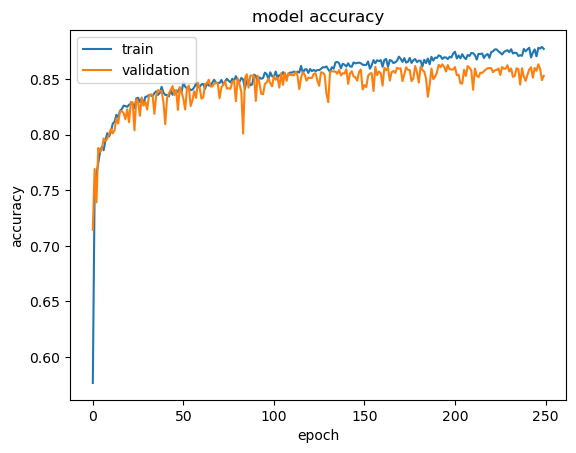

In [130]:

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [131]:
print('max val_accuracy :' + str(max(history.history['val_accuracy'])) + '; ' + 'min val_loss : ' + str(min(history.history['val_loss'])) )

max val_accuracy :0.8634439706802368; min val_loss : 0.32118192315101624


In [261]:
predictOnTest = CNN.predict(input_test)
predictOnTest

1/1 [==============================] - 0s 167ms/step


array([[1.86039415e-08],
       [1.00000000e+00],
       [3.40509176e-10],
       [9.99999464e-01],
       [1.00000000e+00],
       [1.13712427e-04],
       [1.08816810e-11],
       [1.00000000e+00],
       [1.00000000e+00],
       [1.24576308e-10],
       [4.36667161e-11],
       [1.00000000e+00],
       [9.99924242e-01],
       [9.75806937e-02],
       [1.22266993e-05],
       [1.11261215e-07],
       [1.00000000e+00],
       [3.80937809e-10],
       [9.49474052e-03],
       [3.38625580e-01],
       [8.47268084e-14],
       [1.00000000e+00],
       [9.99766231e-01],
       [1.34568010e-08],
       [1.00000000e+00],
       [9.99998987e-01],
       [2.81040935e-04]], dtype=float32)

In [262]:
output_test

array([0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0])

In [263]:
classifiedArrayPredict = myClassify(predictOnTest, 0.5)
np.array(classifiedArrayPredict)

array([0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0])

In [264]:

comparePredictOkNokWithSeq(classifiedArrayPredict, output_test, sequence_test)

['OK : agagggtgtactccaagaagaggaagatgaggctagacgtctctgcatggagtatga',
 'OK : gcaaaaataaatgcttgactctgtagcgggaaggcgtattatgcacaccccgcgccg',
 'OK : ttcgtctccgcgactacgatgagatgcctgagtgcttccgttactggattgtcacca',
 'OK : gtactagagaactagtgcattagcttatttttttgttatcatgctaaccacccggcg',
 'OK : aaattaaaattttattgacttaggtcactaaatactttaaccaatataggcatagcg',
 'OK : tatgaccgaacgagtcaatcagaccgctttgactctggtattactgtgaacattatt',
 'OK : taacattaataaataaggaggctctaatggcactcattagccaatcaatcaagaact',
 'OK : tttctacaaaacacttgatactgtatgagcatacagtataattgcttcaacagaaca',
 'OK : atgcatttttccgcttgtcttcctgagccgactccctataatgcgcctccatcgaca',
 'OK : tattggcttgctcaagcatgaactcaaggctgatacggcgagacttgcgagccttgt',
 'OK : aacgagtcaatcagaccgctttgactctggtattactgtgaacattattcgtctccg',
 'OK : tctgaaatgagctgttgacaattaatcatcgaactagttaactagtacgcaagttca',
 'OK : cactaatttattccatgtcacacttttcgcatctttgttatgctatggttatttcat',
 'OK : gaggtggctatgtgtatgaccgaacgagtcaatcagaccgctttgactctggtatta',
 'OK : catgtcagcctcgacaacttgcataaatgctttcttgtagacgtgccctacgcgc

In [94]:
CNN.layers[0].get_weights()[0][0]

array([[ 0.23533559,  0.42990232, -0.25082487, -0.15267515,  0.26705414,
         0.41497964,  0.27988416,  0.37338895, -0.29958403, -0.04501176],
       [ 0.42684212,  0.07528386,  0.28260273, -0.10901958, -0.15239488,
         0.44041243,  0.01431945,  0.2730652 ,  0.4608476 ,  0.46495697],
       [ 0.45438316,  0.02100177,  0.29724106, -0.24716143, -0.4676595 ,
         0.4724816 , -0.3817394 ,  0.19320472,  0.42271256, -0.05679994],
       [ 0.15253878, -0.10971248, -0.04070297, -0.21874414, -0.08176634,
         0.28545243, -0.43704703,  0.18602677,  0.22525644,  0.47238237],
       [-0.46574974, -0.4418646 , -0.38255867, -0.34078255, -0.23755996,
         0.2713209 ,  0.27443305, -0.03233695,  0.24816659, -0.28621373],
       [ 0.07085161,  0.39532802, -0.03007789, -0.32714292,  0.49284223,
         0.18271512, -0.03359003, -0.21458982, -0.42486927,  0.06511235],
       [ 0.2713358 , -0.27115414,  0.34532204, -0.23495436, -0.43641958,
        -0.3368862 ,  0.12960823,  0.10995054